In [1]:
import srt_util
import matplotlib.pyplot as plt
import numpy as np
import PhysicsTool as pt
import sympy
pt.plotting.set_theme()

In [2]:
def normalize_spectrum(spec: np.ndarray) -> np.ndarray:
    """ Normalize a power spectrum by its maximum value. """
    spec = spec - min(spec)
    spec = spec / max(spec)
    return spec

def plot_sun_scan(hor_file_path: str, ver_file_path: str):
    with srt_util.SRT_HDF_Reader(hor_file_path) as srt_reader:
        offset = srt_reader.get_object_positions()['CenterH']
        spec = normalize_spectrum(srt_reader.get_power_spectrum().sum(axis=1))
        plt.scatter(offset, spec, label = 'Horizontal scan', marker='.')
    with srt_util.SRT_HDF_Reader(ver_file_path) as srt_reader:
        offset = srt_reader.get_object_positions()['CenterV']
        spec = spec = normalize_spectrum(srt_reader.get_power_spectrum().sum(axis=1))
        plt.scatter(offset, spec, label = 'Vertical scan', marker='.')
    return

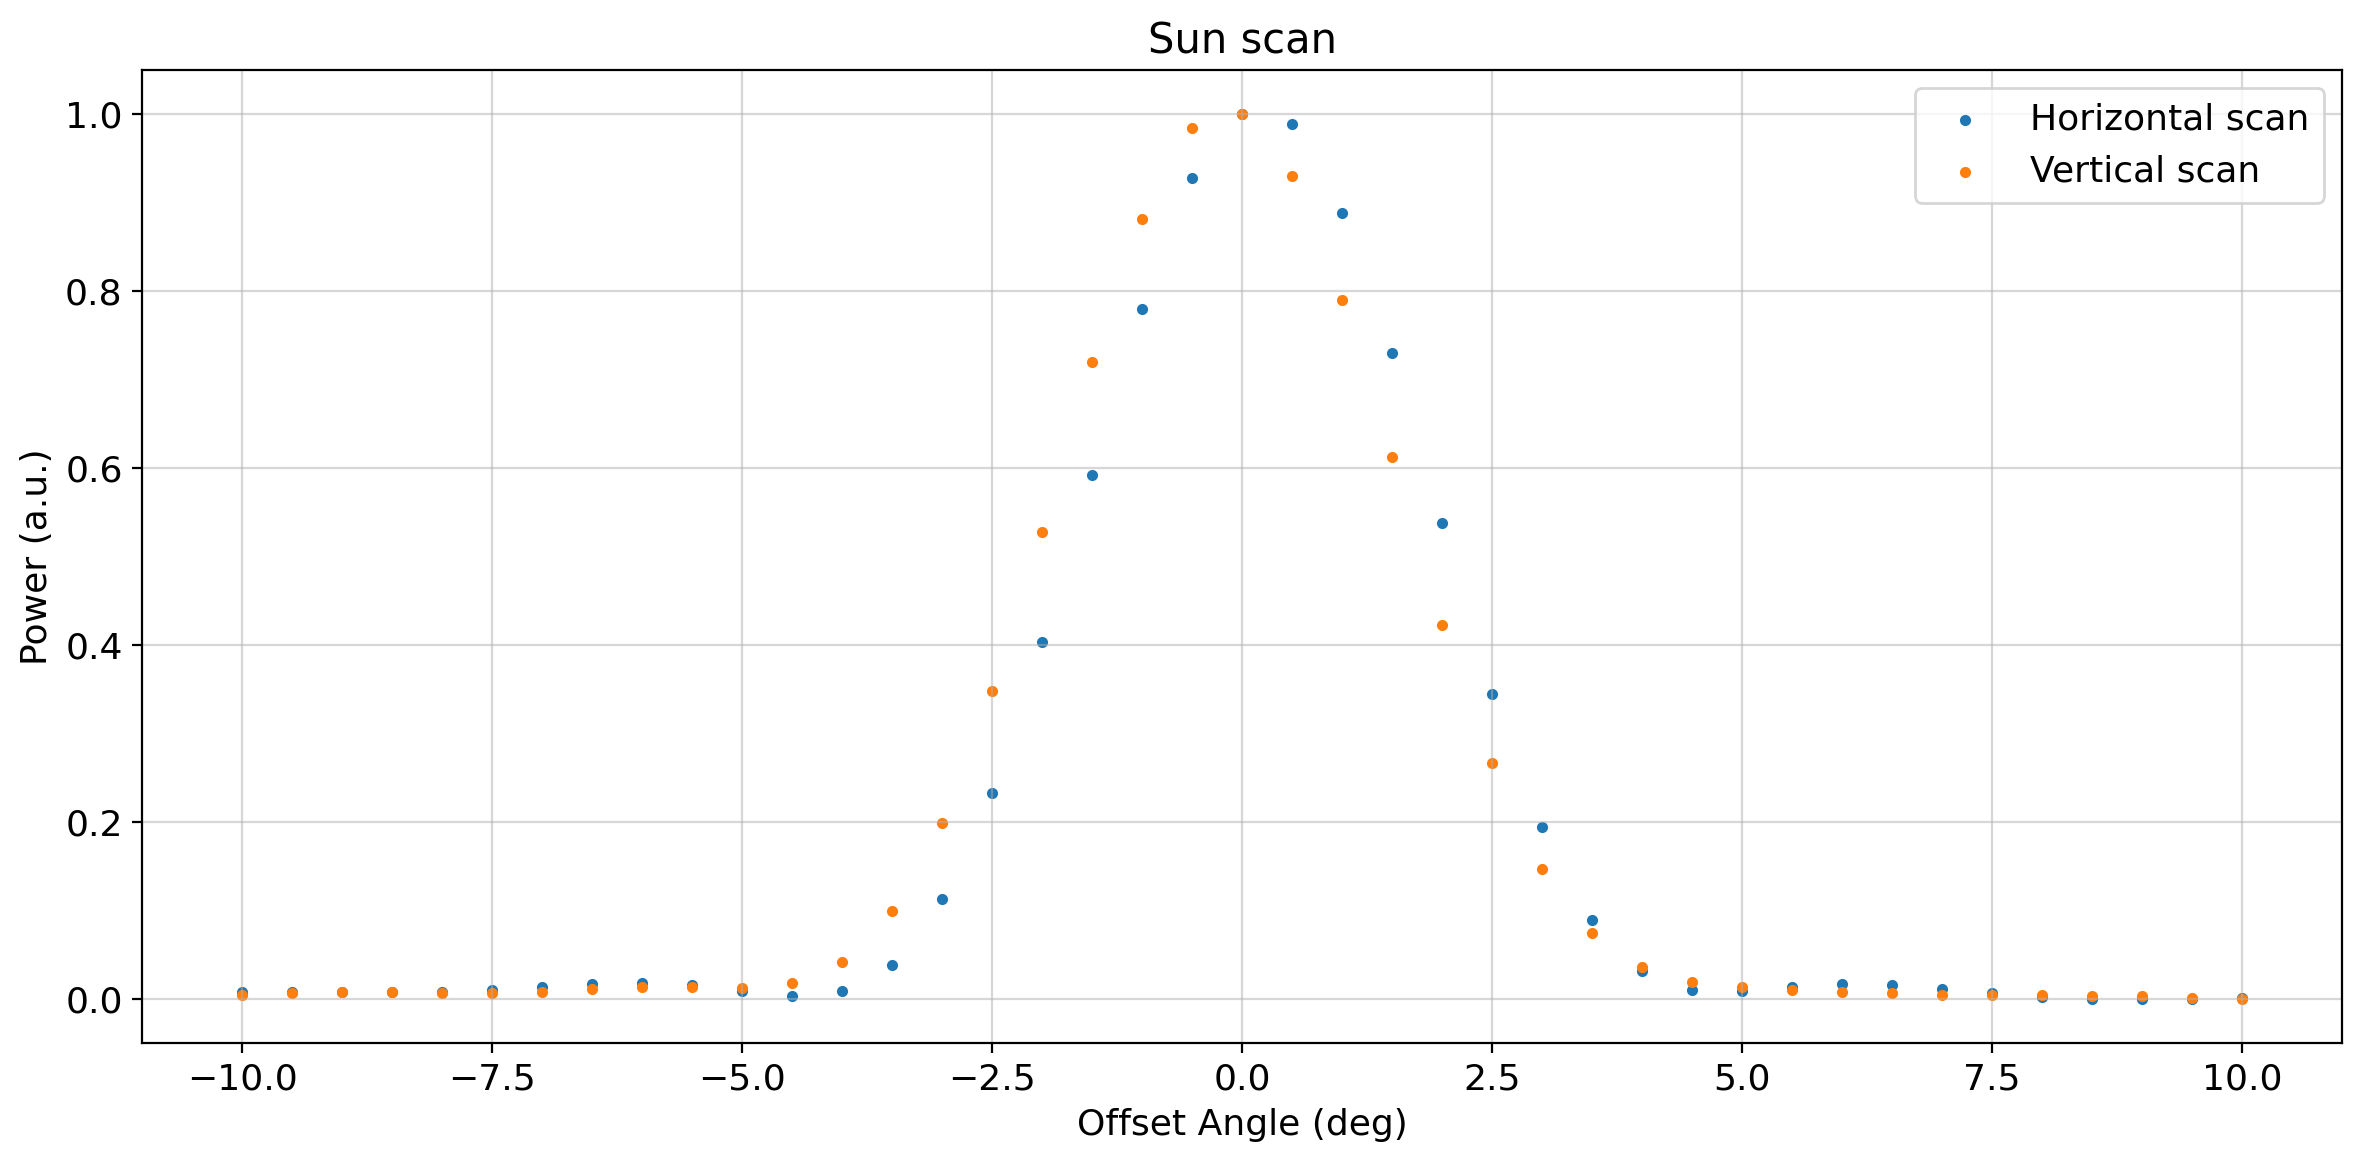

In [3]:
pt.plotting.set_up_plot('Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
plot_sun_scan('Measurements/SunScan/SunScan_Az10deg_Res0deg5_T1120_20251002.hdf',
              'Measurements/SunScan/SunScan_Elv10deg_Res0deg5_T1120_20251002.hdf')
plt.legend()
plt.show()

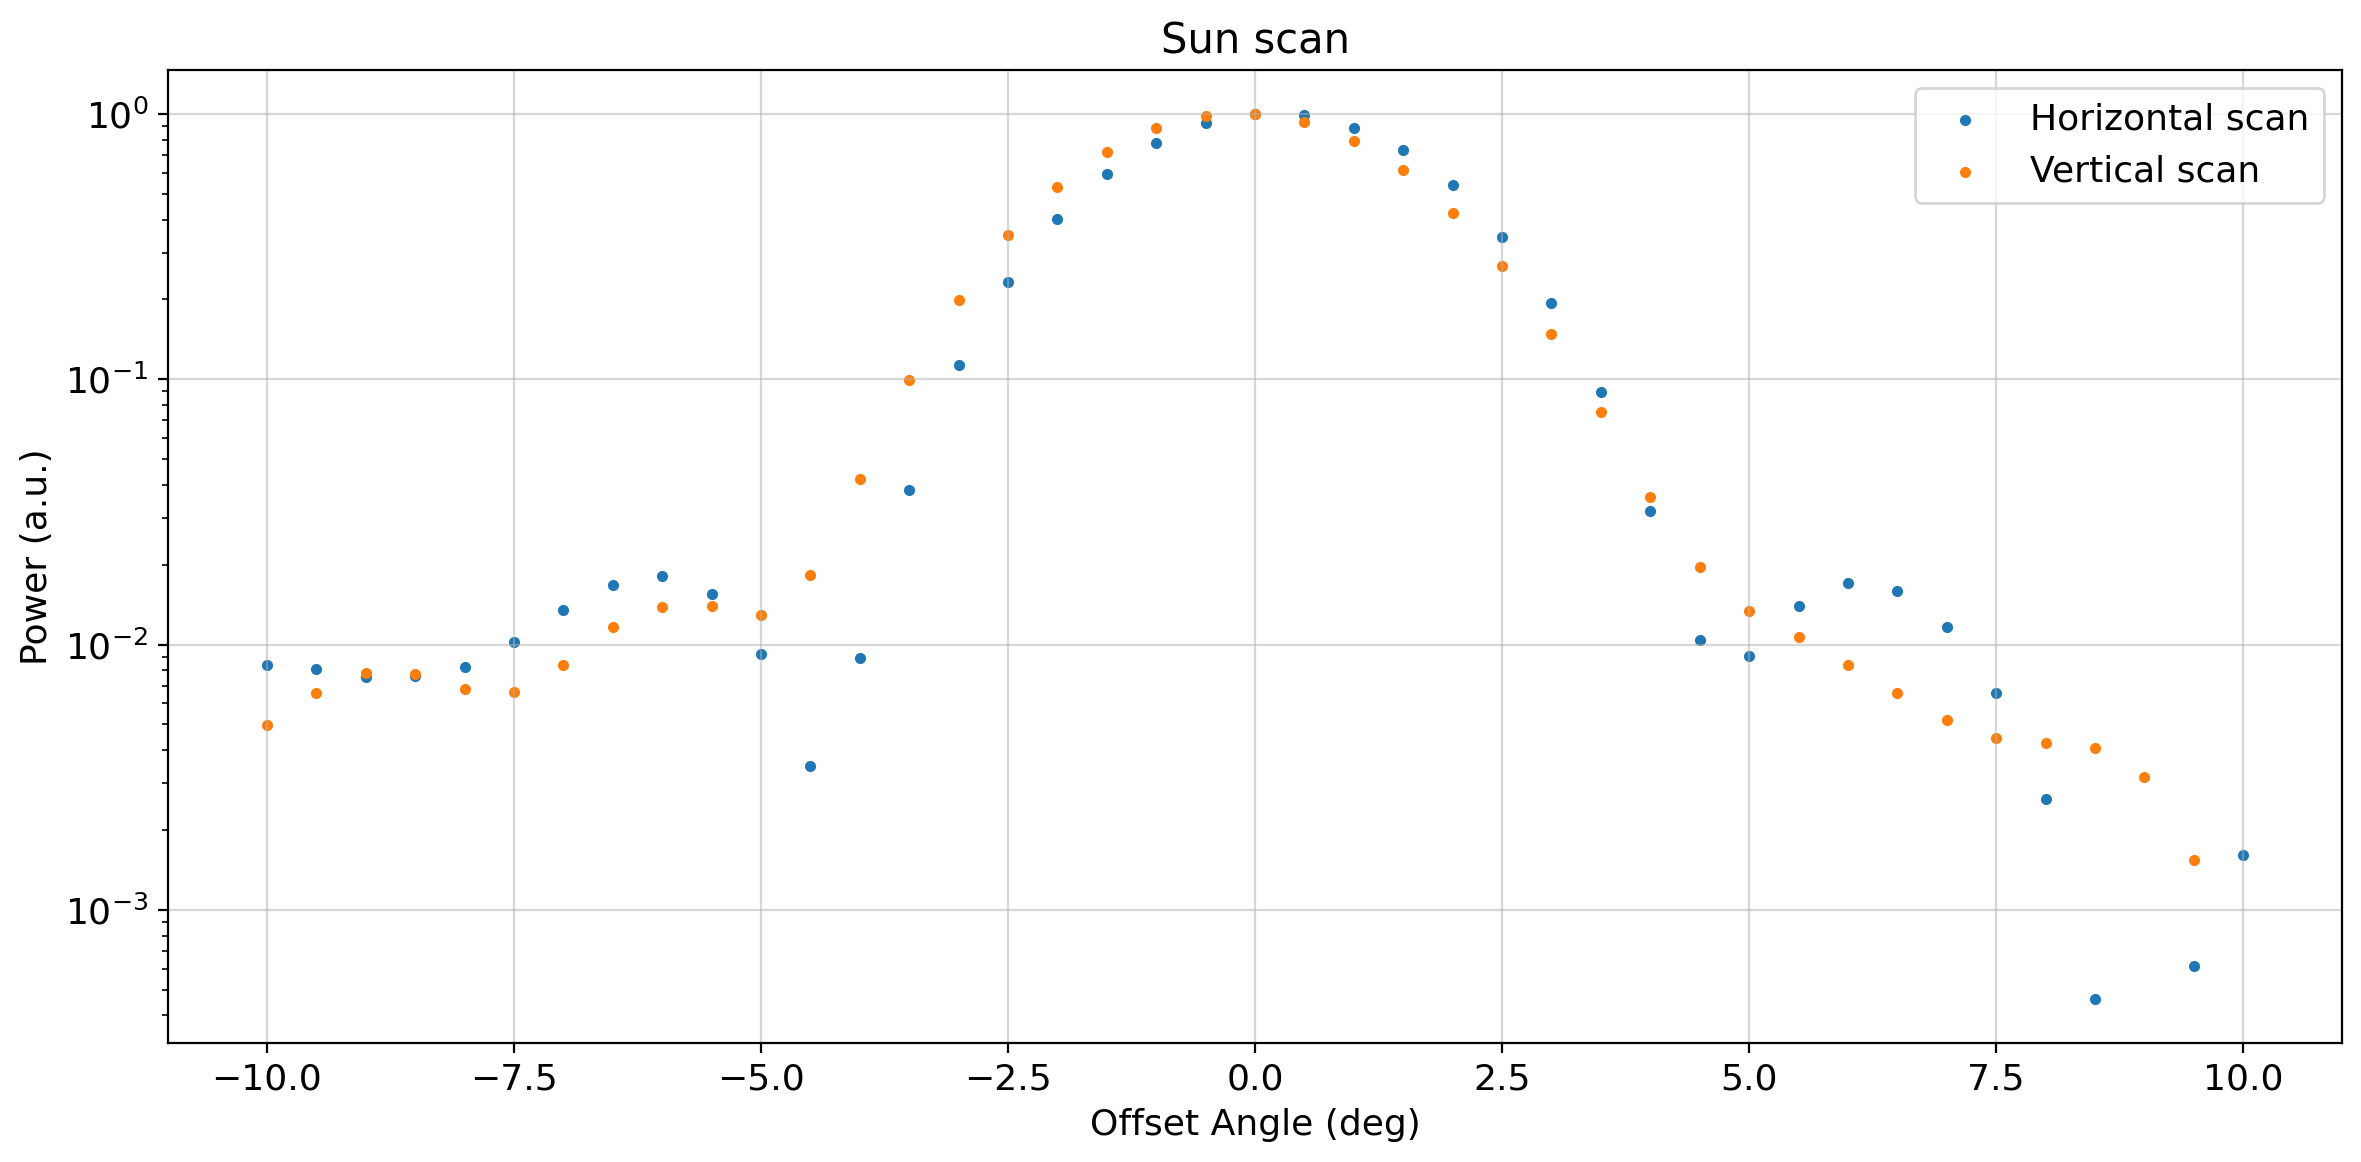

In [4]:
pt.plotting.set_up_plot('Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
plot_sun_scan('Measurements/SunScan/SunScan_Az10deg_Res0deg5_T1120_20251002.hdf',
              'Measurements/SunScan/SunScan_Elv10deg_Res0deg5_T1120_20251002.hdf')
plt.yscale('log')
plt.legend()
plt.show()

the assymetry in the vertical part of the scan might be due to antenna symmetry, maybe the topmost of the three connecting rods

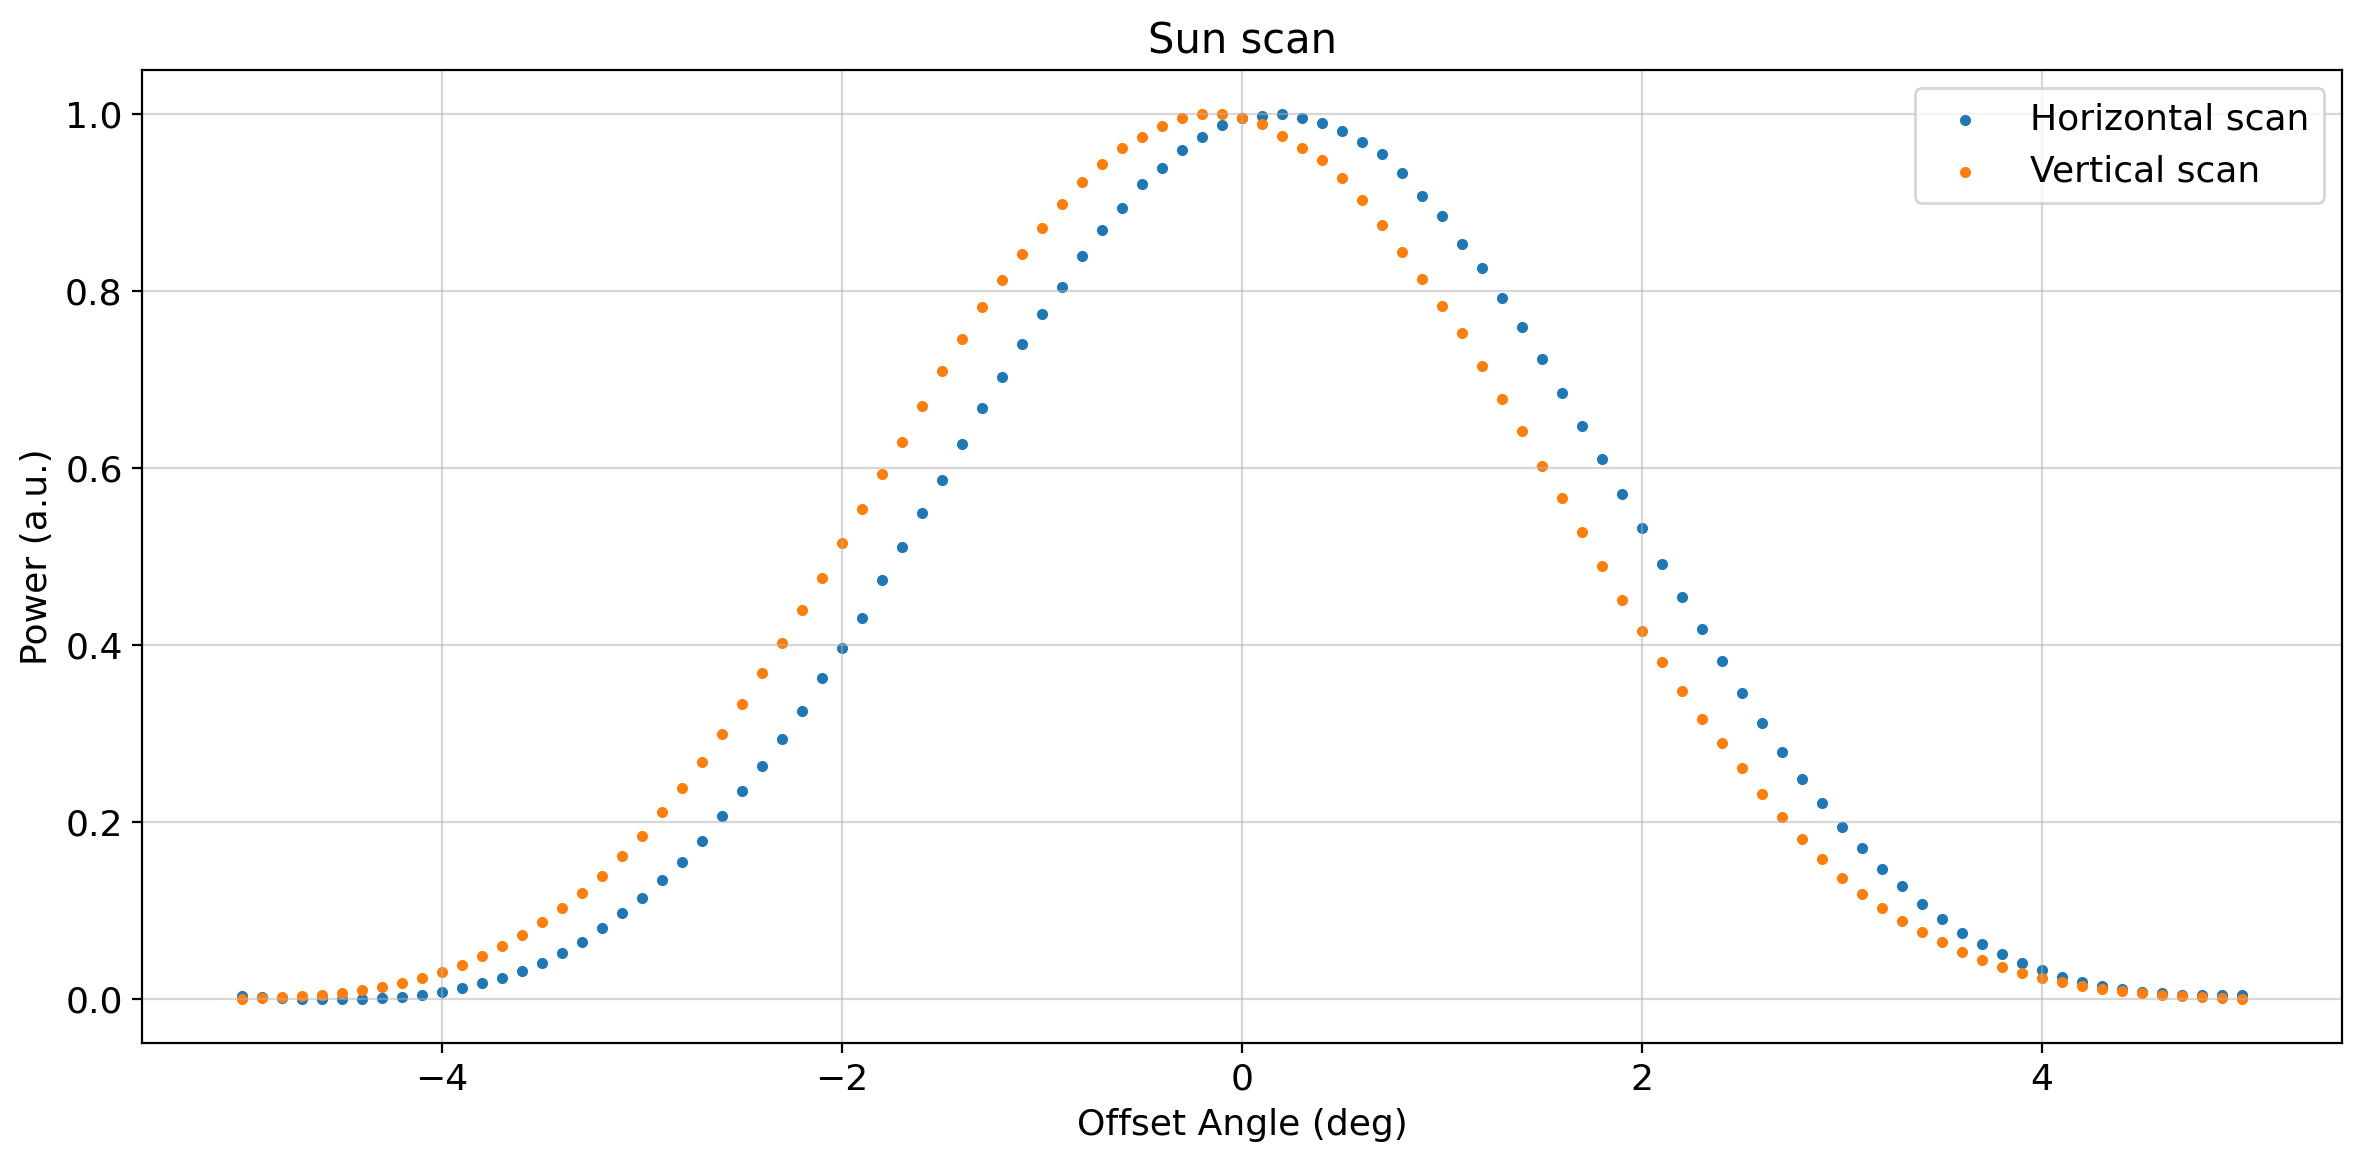

In [5]:
pt.plotting.set_up_plot('Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
plot_sun_scan('Measurements/SunScan/SunScan_Az5deg_Res0deg1_T1130_20251002.hdf',
              'Measurements/SunScan/SunScan_Elv5deg_Res0deg1_T1130_20251002.hdf')
plt.legend()
plt.show()

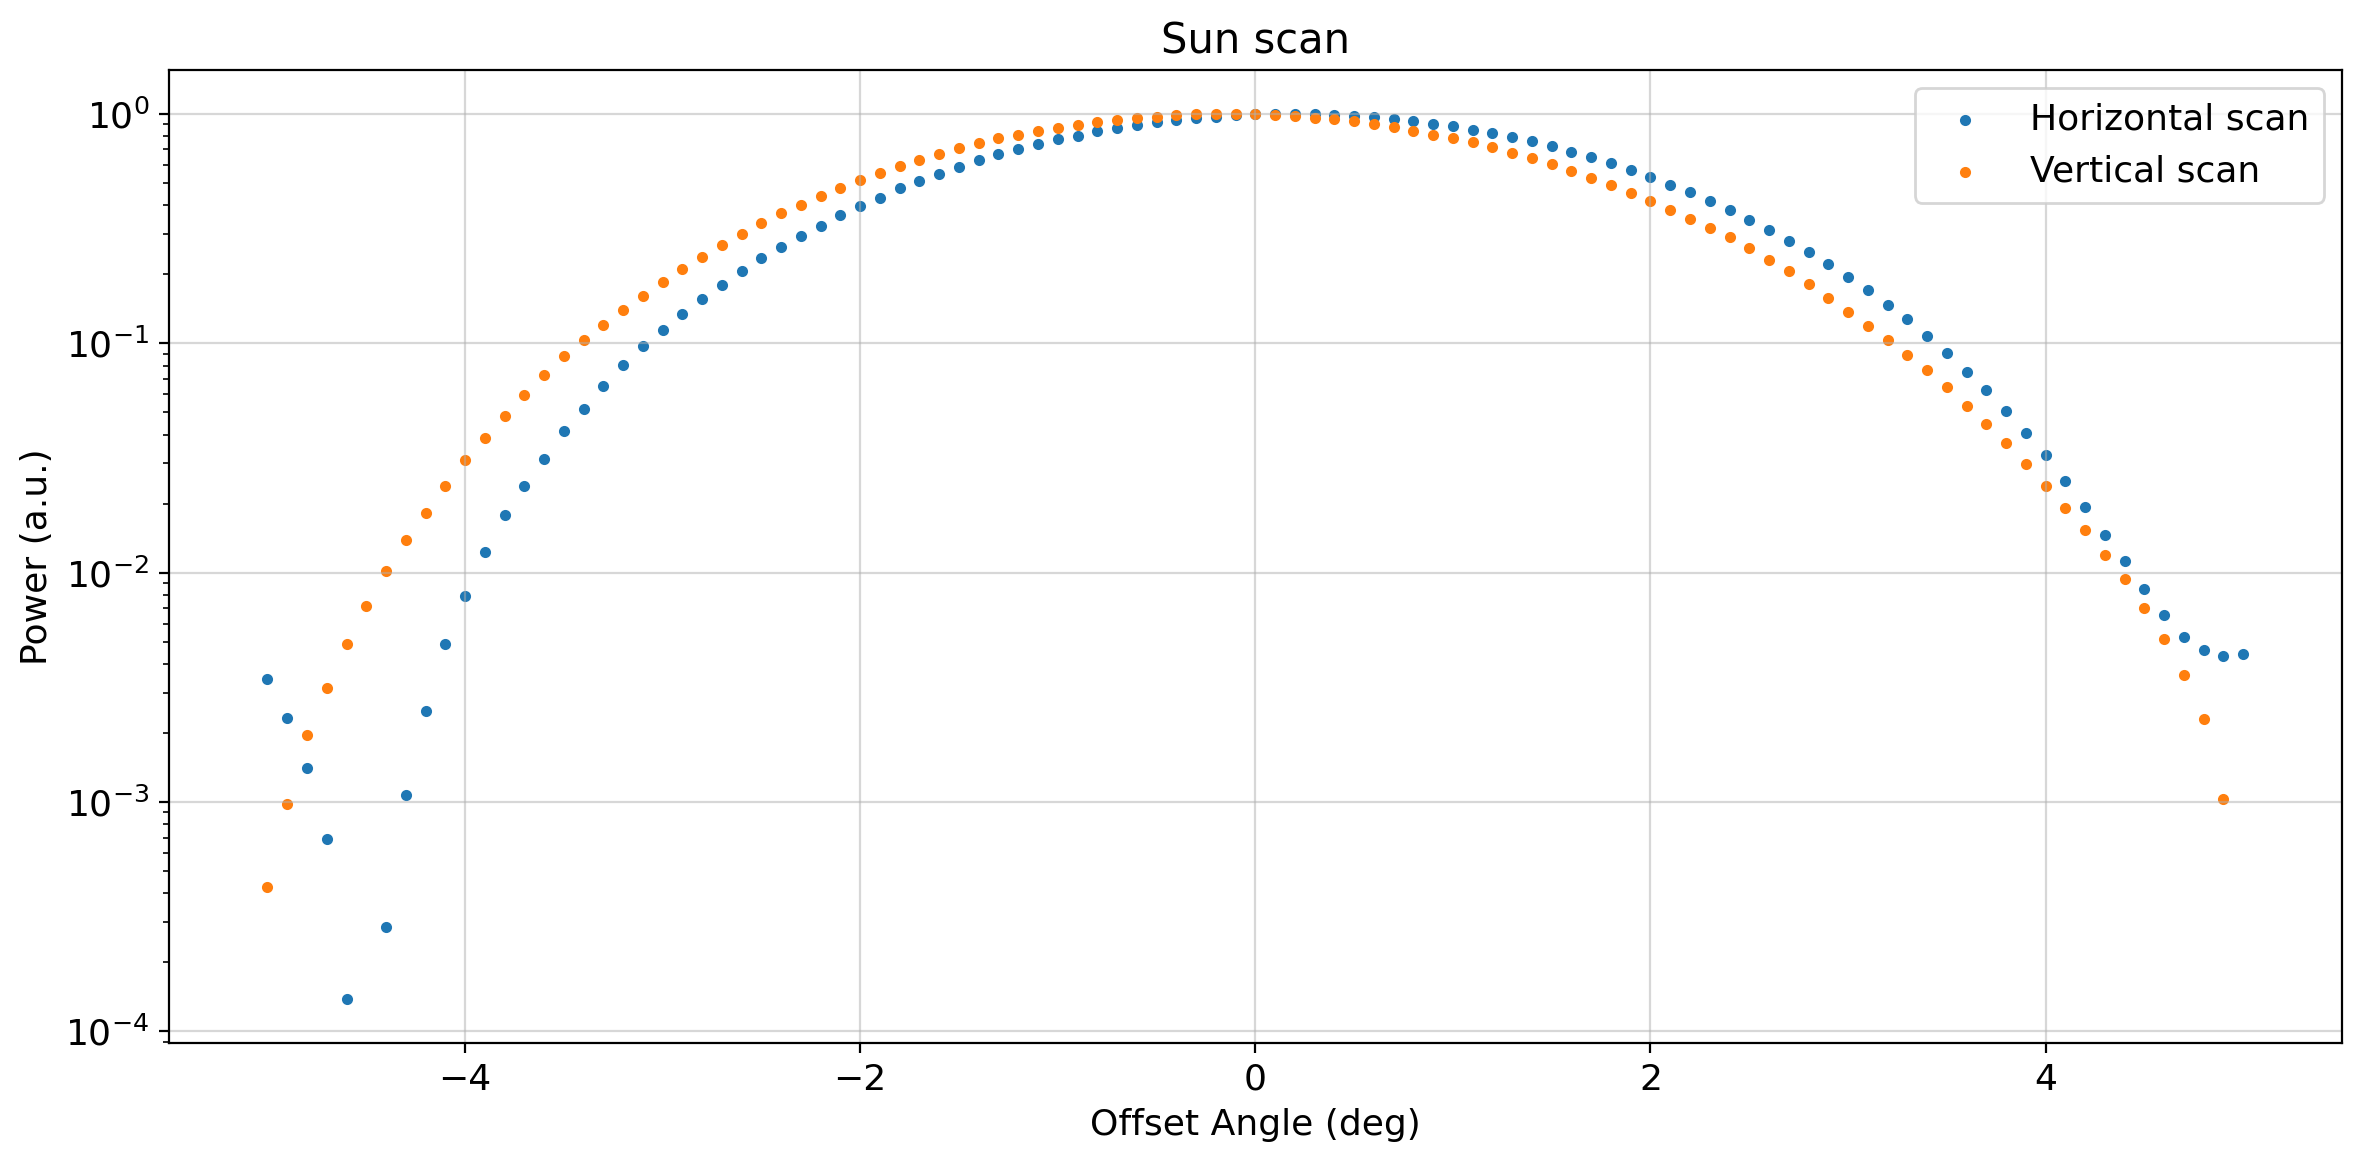

In [6]:
pt.plotting.set_up_plot('Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
plot_sun_scan('Measurements/SunScan/SunScan_Az5deg_Res0deg1_T1130_20251002.hdf',
              'Measurements/SunScan/SunScan_Elv5deg_Res0deg1_T1130_20251002.hdf')
plt.yscale('log')
plt.legend()
plt.show()

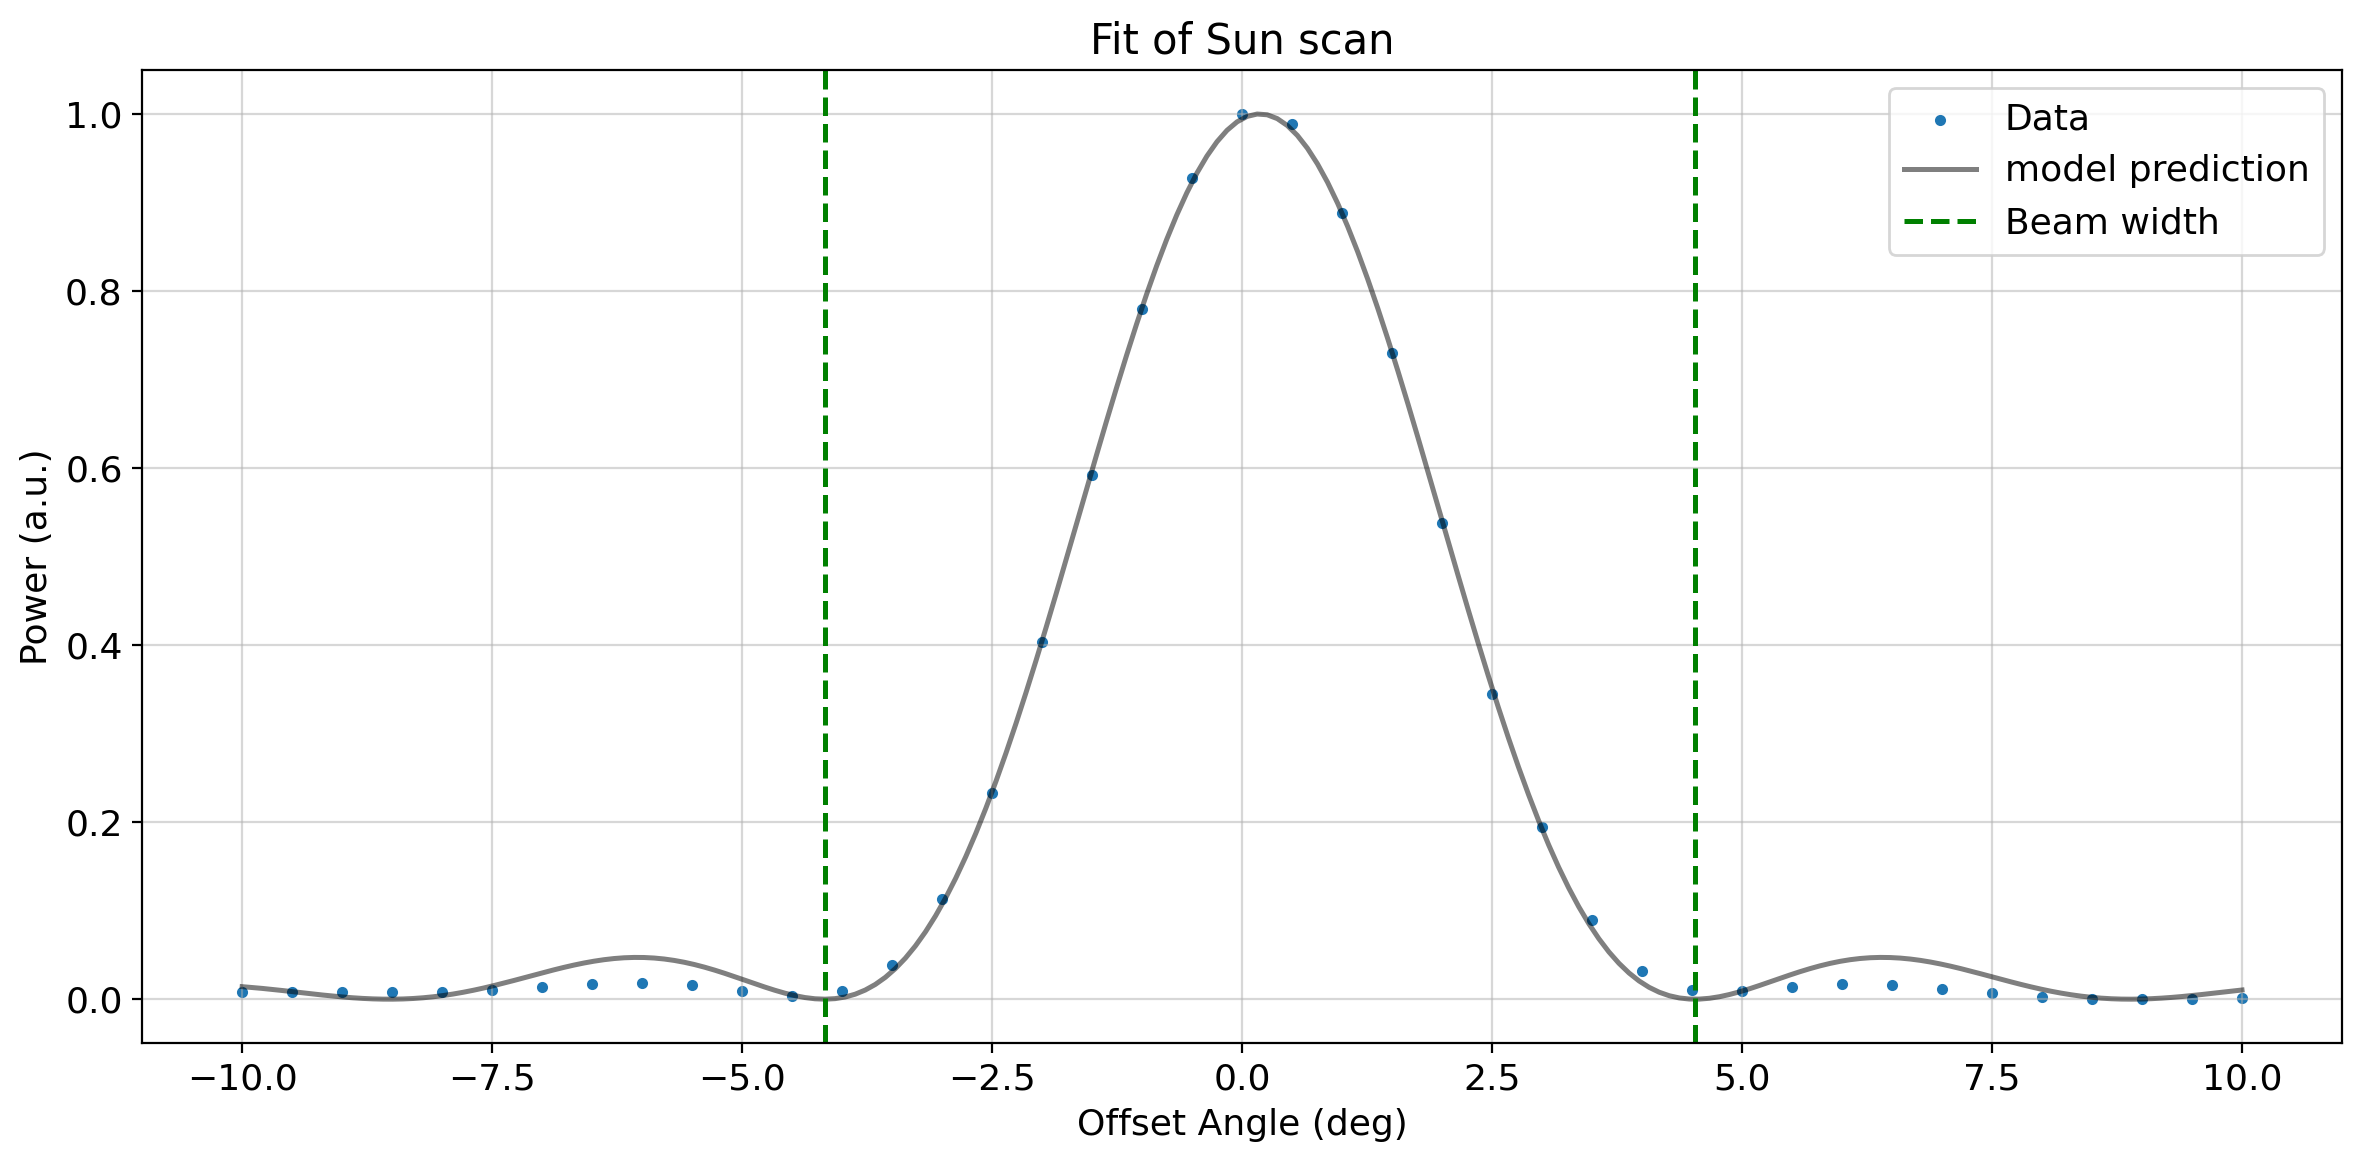

4.35 ± 0.02

\SI{4.35(0.02)}{}


In [7]:
with srt_util.SRT_HDF_Reader('Measurements/SunScan/SunScan_Az10deg_Res0deg5_T1120_20251002.hdf') as srt_reader:
    offset = srt_reader.get_object_positions()['CenterH']
    spec = normalize_spectrum(srt_reader.get_power_spectrum().sum(axis=1))

eps = np.finfo(float).eps

phi,phi_0, P, a = sympy.symbols('phi phi_0 P a')

sinc_arg = (phi - phi_0)*a + eps
gaussian_model_expr = sympy.sin(sinc_arg)**2 / (sinc_arg)**2

f = pt.SympyFunctionalModel(gaussian_model_expr, [phi_0, a], phi)
f.parameters = np.array([0,2])
f.fit(offset, spec)

pt.plotting.set_up_plot('Fit of Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')

plt.scatter(offset, spec, label = 'Data', marker='.')
f.plot_prediction_smooth(errorband=False)
beam_width_mean, beam_width_cov = pt.propagate_error(sympy.pi / a, f.parameter_symbols, f.parameters, f.parameter_cof() * f.m_0**2)
beam_width = pt.UErr(beam_width_mean, beam_width_cov[0,0]**0.5)

center = f.parameters[0]

plt.axvline(center + beam_width_mean, color='green', linestyle='--', label='Beam width')
plt.axvline(center - beam_width_mean, color='green', linestyle='--')

plt.legend()
plt.show()

display(beam_width)
print(beam_width.latex())

Skript p.3 says that the main-beam intensity can be approximated as gaussian with the peak in the center

In [8]:
def fit_gaussian_to_main_bulb(file_path: str, horizontal: bool):
    with srt_util.SRT_HDF_Reader(file_path) as srt_reader:
        offset = srt_reader.get_object_positions()['CenterH' if horizontal else 'CenterV']
        spec = normalize_spectrum(srt_reader.get_power_spectrum().sum(axis=1))

    sigma, phi_0 = sympy.symbols('sigma phi_0')

    gaussian_model_expr = sympy.exp(-((phi - phi_0)**2) / (2*sigma**2))
    f = pt.SympyFunctionalModel(gaussian_model_expr, [phi_0, sigma], phi)
    f.parameters = np.array([0, 1])
    f.fit(offset, spec)

    # FWHM = sqrt(2*ln(2)) * sigma
    fwhm_expr = sympy.sqrt(2*sympy.log(2))*sigma
    fwhm_mean, fwhm_cov = pt.propagate_error(fwhm_expr, f.parameter_symbols,f.parameters, f.parameter_cof() * f.m_0**2)
    fwhm = pt.UErr(fwhm_mean, fwhm_cov[0,0]**0.5)

    center_mean = f.parameters[0]
    center_err = f.parameter_cof()[0,0]**0.5 * f.m_0
    center = pt.UErr(center_mean, center_err)

    print('Center:')
    display(center)
    print(center.latex())
    print()

    print('FWHM:')
    display(fwhm)
    print(fwhm.latex())

    pt.plotting.set_up_plot('Fit of Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
    plt.scatter(offset, spec, label = 'Data', marker='.')
    f.plot_prediction_smooth(errorband=False)

    plt.axvline(center_mean + fwhm_mean, color='green', linestyle='--', label='FWHM')
    plt.axvline(center_mean - fwhm_mean, color='green', linestyle='--')
    
    plt.axvline(center_mean, color='orange', linestyle='--', label = 'center')
    

    plt.legend()
    plt.show()

Center:


0.179 ± 0.006

\SI{0.179(0.006)}{}

FWHM:


1.862 ± 0.006

\SI{1.862(0.006)}{}


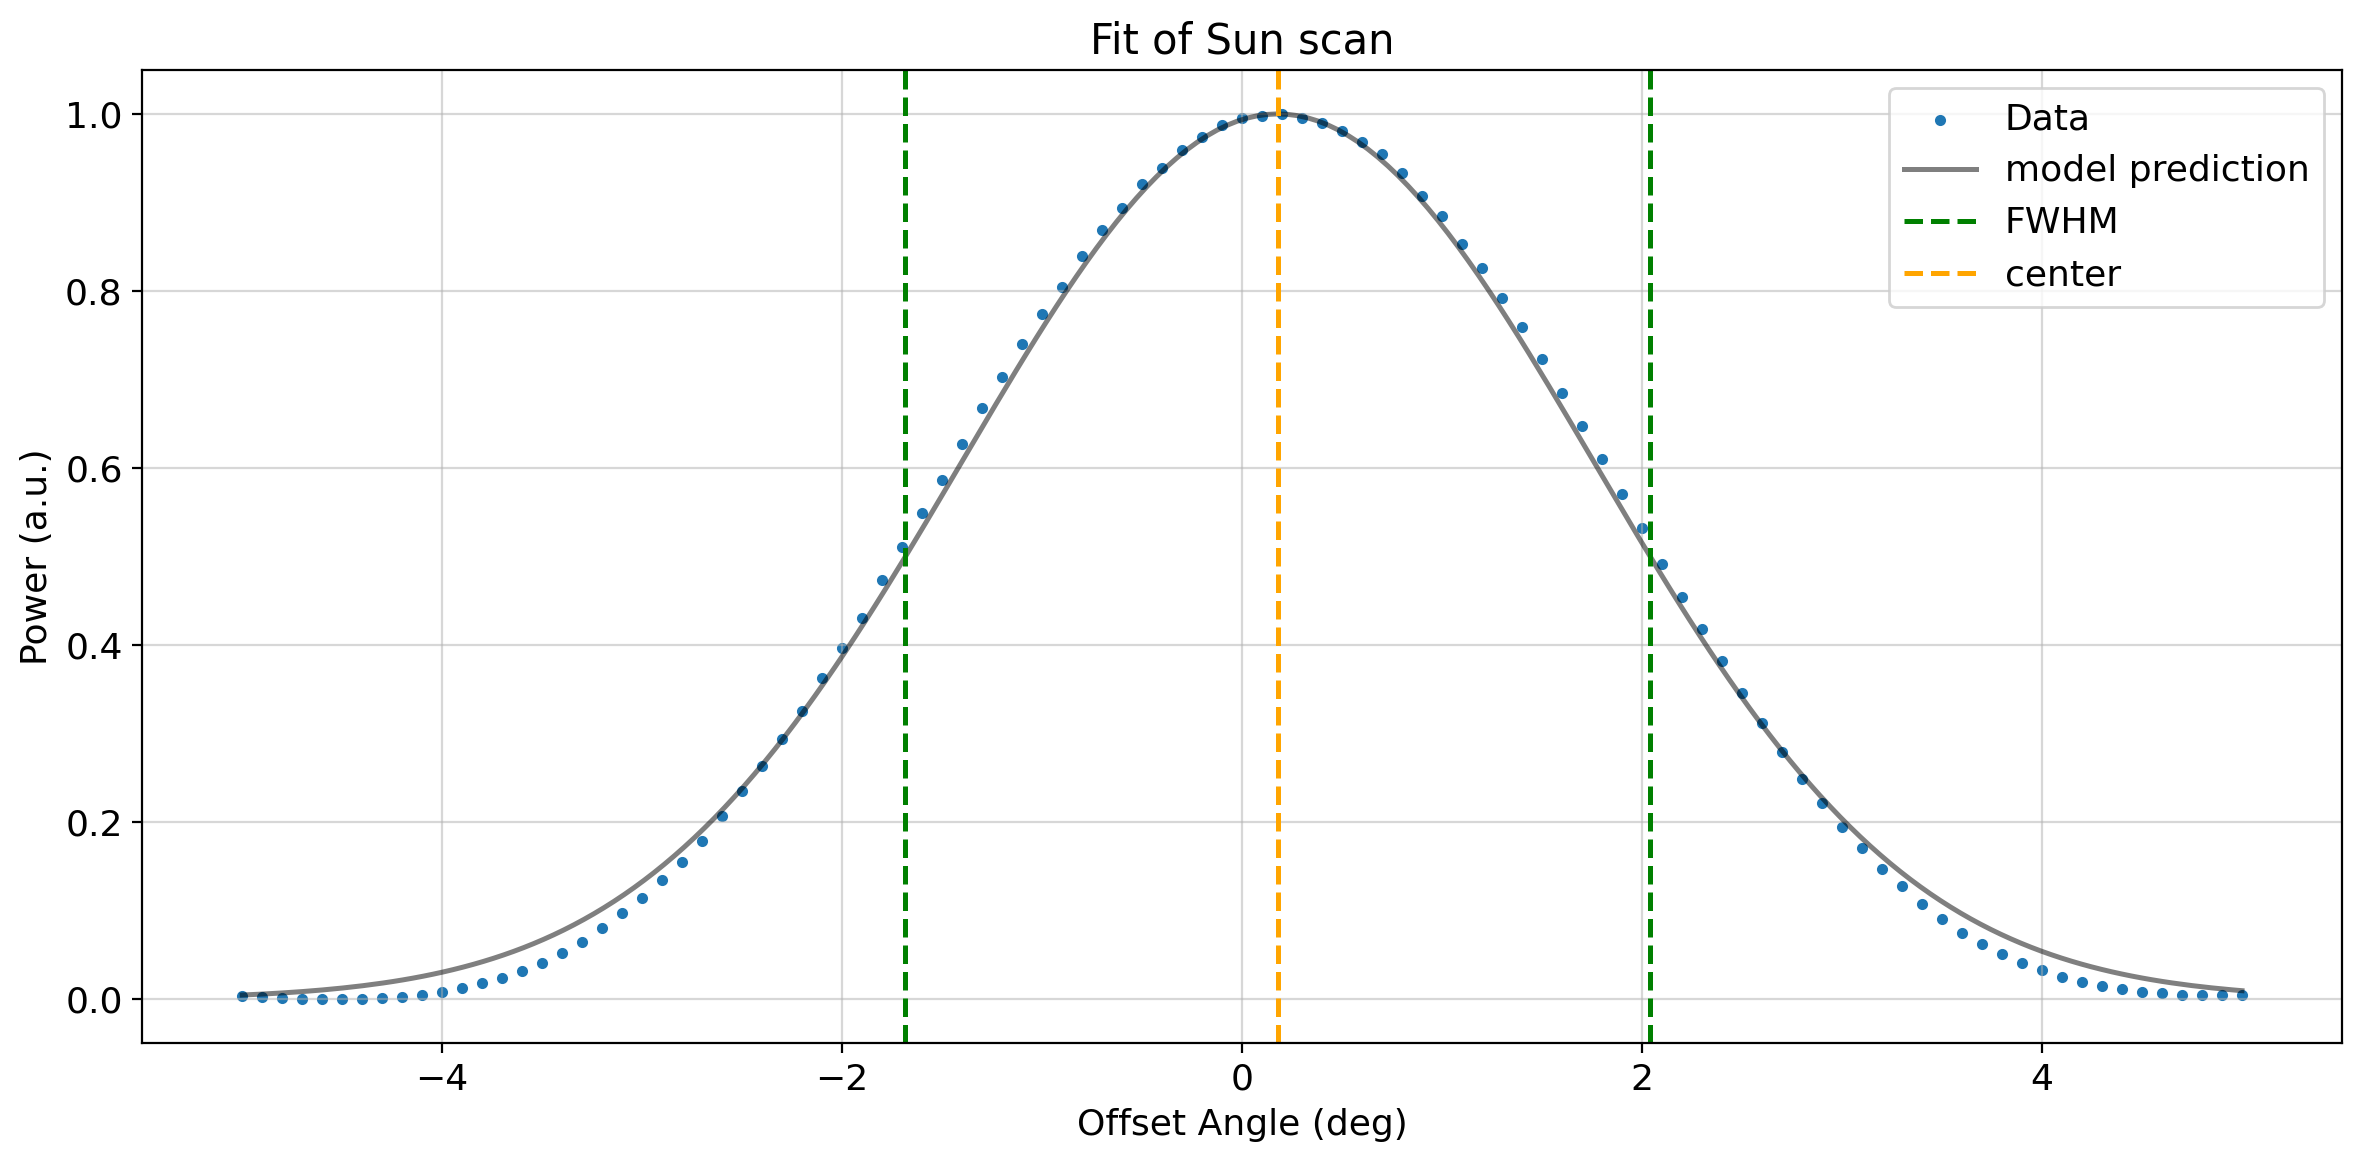

In [9]:
fit_gaussian_to_main_bulb('Measurements/SunScan/SunScan_Az5deg_Res0deg1_T1130_20251002.hdf', horizontal=True)

Center:


-0.131 ± 0.005

\SI{-0.131(0.005)}{}

FWHM:


1.876 ± 0.005

\SI{1.876(0.005)}{}


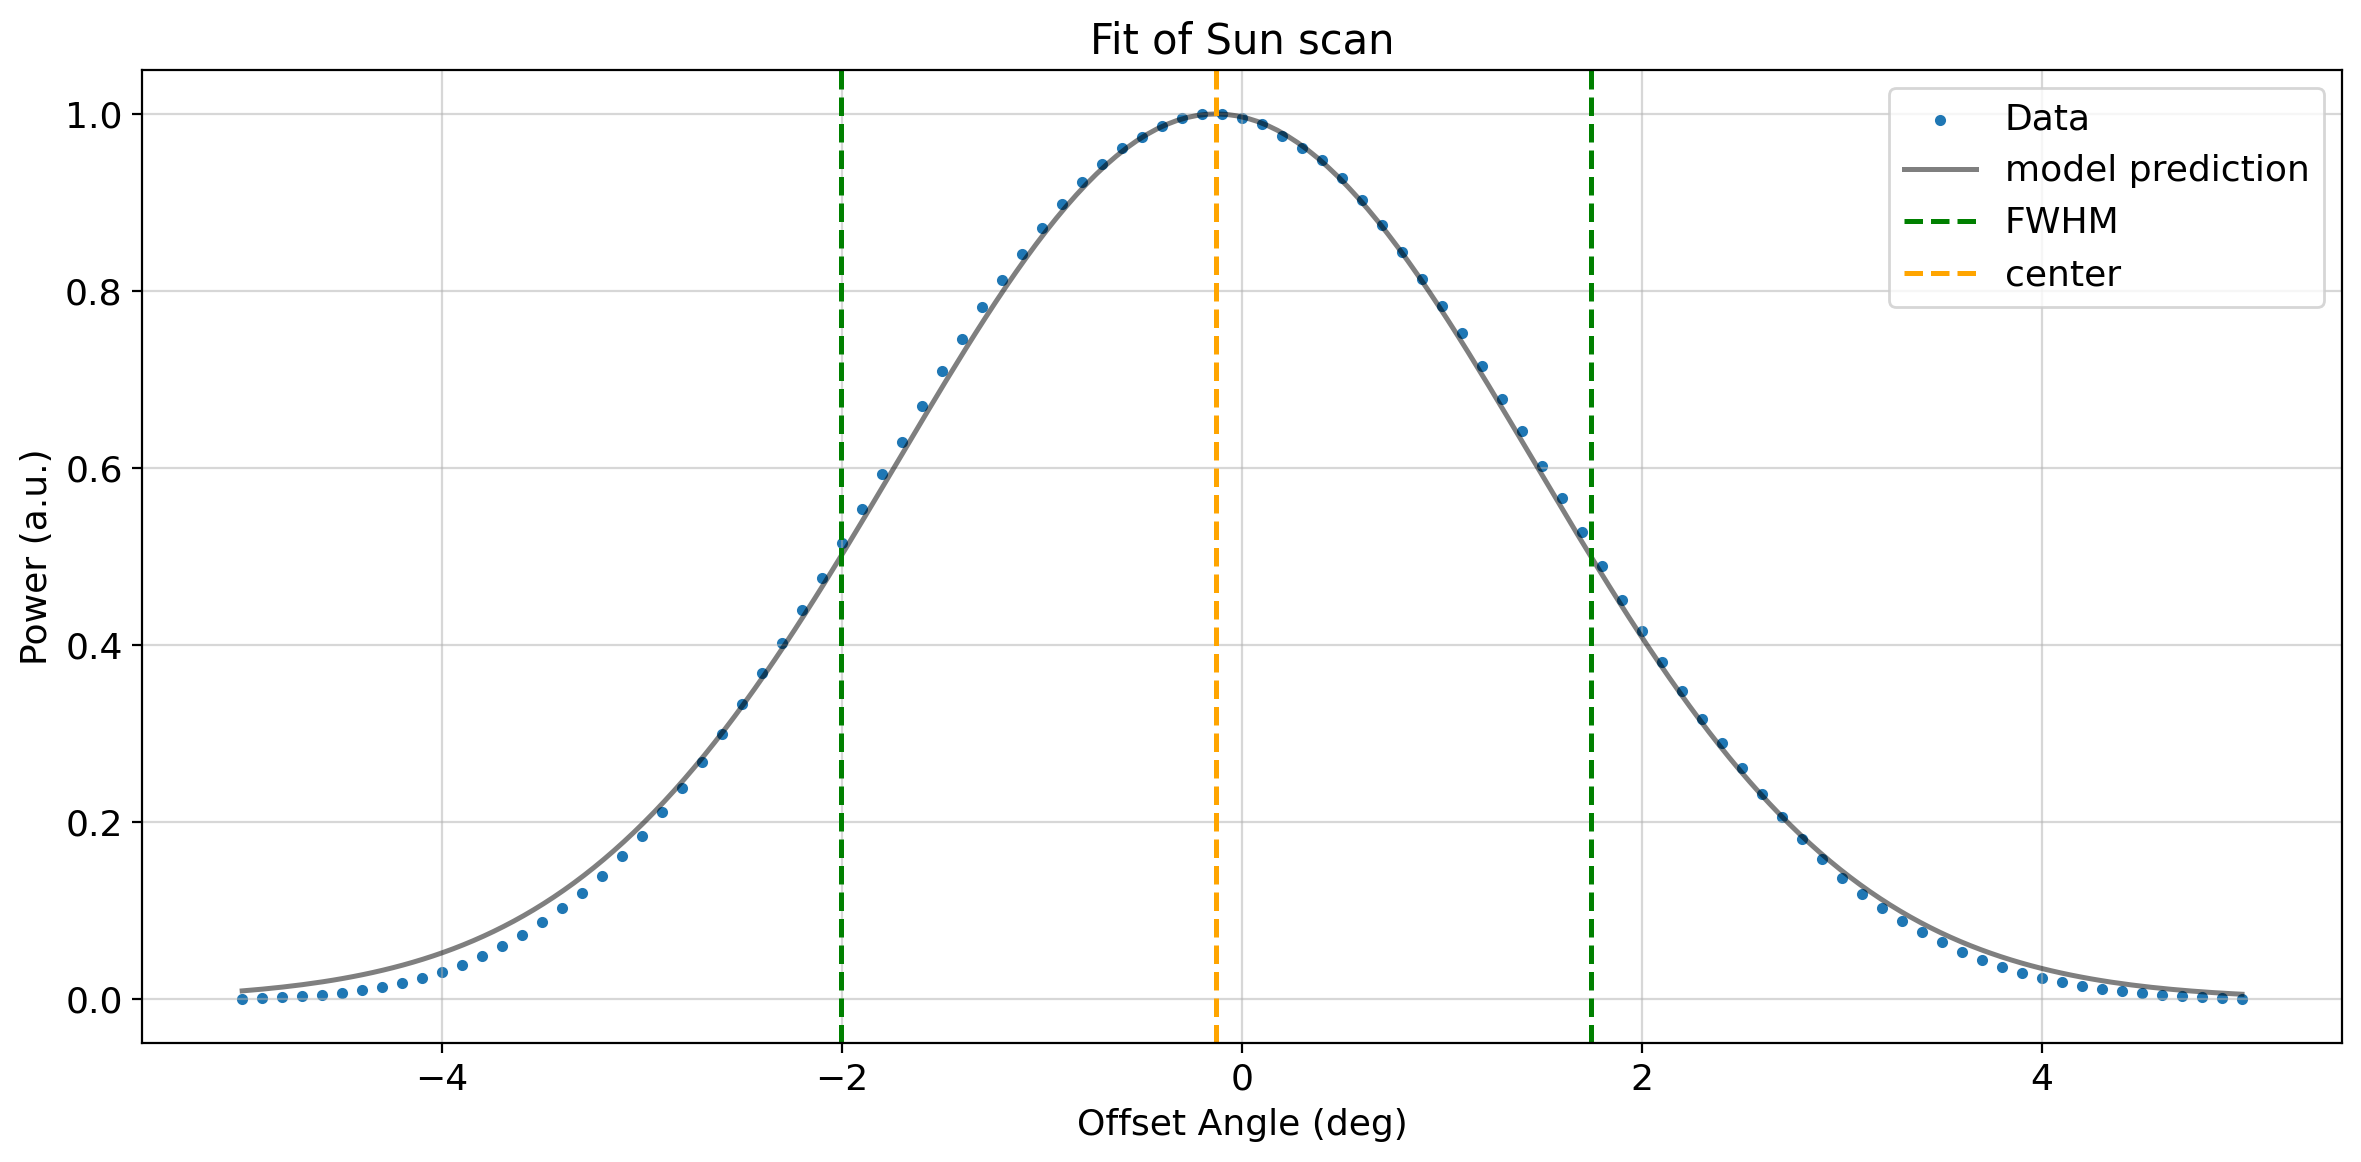

In [10]:
fit_gaussian_to_main_bulb('Measurements/SunScan/SunScan_Elv5deg_Res0deg1_T1130_20251002.hdf', horizontal=False)